<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" width="25%" /> </h1>

<H2 align='center'>Análisis de Sistemas de Potencia III - ELI348</H2>

<h3 align='center'> Preparedo por  Miguel Huerta </h3>

**Resumen**  
El presente documento, busca ser una guía que facilite la implementación y realización de estudios dinámicos de $\texttt{PowerFactory}$, por medio de $\texttt{Python}$. Bajo esta premisa se presentarán comandos, funciones y scripts que facilitan la interacción entre ambos softwares, estableciendo como caso demostrativo la desconexión del generador 2 (conectado a la barra 3) del modelo $\texttt{IEEE9}$ presente en la librería de ejemplos de $\texttt{PowerFactory}$.<br><br>

<h1 align='center'> <img src="https://www.researchgate.net/profile/Yue_Song15/publication/303381482/figure/fig2/AS:368524460609538@1464874486665/Diagram-of-the-IEEE-9-bus-test-system.png" width="55%" /> </h1>


En una primera instancia, se establecerá la conexión con el módulo $\texttt{powerfactory.pyd}$, presente en la ruta predefinida.

In [1]:
import platform, os, sys
sys.path.append('C:\Program Files\DIgSILENT\PowerFactory 2020 SP3\Python\\'+'.'.join(platform.python_version().split('.')[0:2]))
import powerfactory
app = powerfactory.GetApplication('Miguel','') 


En caso de que esta script no funcione, basta con añadir la ruta manualmente, es decir:<br><br>

```python
sys.path.append('C:\Program Files\DIgSILENT\PowerFactory 2020 SP3\Python\3.6')
import powerfactory
app = powerfactory.GetApplication('UserName','Password')
```

<br>
Además, como se aprecia en la última línea, para generar la conexión con el software hay que ingresar con el nombre de usuario y la contraseña, que en caso de estar utilizando la versión estudiante este ultima queda como carácter vacío ('Password' =''). Con lo cual, establecida la conexión, se procede a cargar el proyecto a estudiar, en conjunto a algunos comandos de ejecución

In [2]:
try:
    project = app.ActivateProject("Nine-bus System") 
    prj = app.GetActiveProject()
    print('Nombre del Proyecto: {:s}'.format(str(prj).split('\\')[-1].split('.')[0]))
    ldf = app.GetFromStudyCase('ComLdf')
    ini = app.GetFromStudyCase('ComInc')
    sim = app.GetFromStudyCase('ComSim')
    events = app.GetFromStudyCase('IntEvt')
    comres = app.GetFromStudyCase('ComRes'); 
    elmRes = app.GetFromStudyCase('Results.ElmRes')
except:
    print('El modelo cargado no existe')

Nombre del Proyecto: Nine-bus System


Como ya fue señalado en el resumen del documento, el sistema a trabajar es el modelo $\texttt{IEEE9}$, que previo a la ejecución por medio de $\texttt{Python}$ debe ser precaragado a la libreria de $\texttt{Digsilent}$. En tanto, los comandos cagados son: <br>

$~~~~~~~~~~~
\begin{array}{lcl}
\texttt{ldf}&:&\text{Flujo de potencia}\\
\texttt{ini}&:&\text{Iniciación dinámica}\\
\texttt{sim}&:&\text{Simulaciones transitorias}\\
\texttt{events}&:&\text{Carpeta de eventos}\\
\texttt{comRes}&:&\text{Caja de resultados}\\
\end{array}
$

En consecuencia, establecidas las funciones se procederá al reconocimiento de los escenarios implementados en el modelo, en conjunto a la activación del estado a estudiar.


In [3]:
try:
    for num, scen in enumerate(app.GetProjectFolder('scen').GetChildren(1)):
        if num==0:
            print('Listado de escenarios')
        print(str(num) +'  '+ str(scen).split('\\')[-1].split('.')[0])    
    scen = app.GetProjectFolder('scen').GetChildren(1)
    scen[0].Activate()
    print('\nActive scene : {:s}'.format(str(scen[0]).split('\\')[-1].split('.')[0]))
except:
    print('No hay implementado algún escenario')

No hay implementado algún escenario


Como se aprecia en el retorno de la script, para este caso en concreto no hay implementado algún escenario que modifique alguna variable, estado o parámetro del sistema. <br><br>

A continuación, se presenta un código en el cual se describe el procedimiento para añadir variables a la caja de resultados, que para el objetivo de este ejercicio se añadirán variables que describen la dinámica de las cargas, barras y maquinas sincrónicas.


In [4]:
buses = app.GetCalcRelevantObjects("*.ElmTerm") 
syms  = app.GetCalcRelevantObjects("*.ElmSym") 
loads = app.GetCalcRelevantObjects("*.ElmLod") 
lines = app.GetCalcRelevantObjects("*.ElmLne") 

LBus, LSyms, Lloads, Llines = {}, {}, {}, {}
for bus in buses:
    LBus[bus.loc_name] = bus
    elmRes.AddVars(bus,
                   'm:u',         # voltage ('m:u')
                   'm:phiu',      # angle ('m:phi')
                   'm:fehz',      # frequency ('m:fehz')
                   )  

for sym in syms:
    LSyms[sym.loc_name]  = sym
    elmRes.AddVars(sym, 
                   's:ve',    # p.u  Excitation Voltage
                   's:pt',    # p.u.   IN    Turbine Power
                   's:ut',    # p.u.   OUT   Terminal Voltage
                   's:ie',    # p.u.   OUT   Excitation Current
                   's:xspeed',# p.u.   OUT   Speed
                   's:xme',   # p.u.   OUT   Electrical Torque
                   's:xmt',   # p.u.   OUT   Mechanical Torque
                   's:cur1',  # p.u.   OUT   Positive-Sequence Current, Magnitude
                   's:P1',    # MW     OUT   Positive-Sequence, Active Power
                   's:Q1',    # Mvar   OUT   Positive-Sequence, Reactive Power
                   'c:firel', # deg    Rotor angle with reference to reference machine angle 
                   )

for load in loads:                        # creating channels for:
    Lloads[load.loc_name] = load
    elmRes.AddVars(load, 'n:u1:bus1',     # voltage ('m:u')
                         'm:I1:bus1',     # current ('s:P1')
                         'm:Psum:bus1',   # active power ('s:P1')
                         'm:Qsum:bus1')   # reactive power ('s:Q1')
for line in lines:
    Llines[line.loc_name] = line

Del código presentado, se desprende que la creación de diccionarios permite una fácil manipulación de los elementos a estudiar. En base a lo anterior, se procede a crear el evento que permiten emular la condición de falla. 


In [5]:
def clearSimEvents():
  faultFolder = app.GetFromStudyCase("Simulation Events/Fault.IntEvt")
  cont = faultFolder.GetContents()
  for obj in cont:
    obj.Delete()

clearSimEvents()
evt1 = events.CreateObject('EvtSwitch', 'Desconexión del G2')
evt1.p_target = LSyms['G2']
evt1.time = 1.0  

Como se aprecia en la script, el uso de diccionarios facilita el reconocimiento del elemento seleccionado. En tanto, para el correcto funcionamiento se ha establecido el tiempo de falla en 1$\texttt{s}$. En tanto, dado el tipo de evento estudiado, es necesario configurar el siguiente solver.

In [7]:
sim.tstop = 6.0
sim.Execute()

0

Un indicativo de que la simulación fue efectuada es el retorno de un cero por parte de la función $\texttt{sim.Execute()}$. Por consiguiente, a continuación se presenta la exportación de las variables de la caja de resultado:


In [8]:
comres.ciopt_head = 1   # añade una fila que describe la variable 
comres.iopt_csel = 0    # retorna todas las variables de la caja de resultados (configurada previamente)
comres.iopt_tsel = 0    # retorna todas las variables con dependencia temporal
comres.iopt_locn = 1    # Cambio los labels de las barras  un formato mas acotado
comres.iopt_sep = 1     # Separador del sistema
comres.pResult = elmRes # Define sobre cual caja de resultados opera
comres.f_name = os.getcwd()+'\\Results.csv' # Nombre del archivo
comres.Execute()        # Recomendación: Utilizar la configuración presentada

0

Nuevamente, el retorno de un cero de la función $\texttt{comres.Execute()}$ indica que está ya opero y genero el archivo $\texttt{Results.csv}$, en la ruta indicada (que por defecto, en la script se configura la carpeta donde esta el archivo de ejecución). En consecuencia, obtenidos los datos se procede cargar las librerías complementarias a $\texttt{Python}$, para la manipulación y ploteo de información. Cabe destacar que este procedimiento puede realizarse en el software a elección.

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

Data = pd.read_csv(os.getcwd()+'\\Results.csv'); Data

,Results,Bus 1,Bus 1.1,Bus 1.2,Bus 2,Bus 2.1,Bus 2.2,Bus 3,Bus 3.1,Bus 3.2,...,Load A.2,Load A.3,Load B,Load B.1,Load B.2,Load B.3,Load C,Load C.1,Load C.2,Load C.3
0,b:tnow in s,m:u in p.u.,m:phiu in deg,m:fehz in Hz,m:u in p.u.,m:phiu in deg,m:fehz in Hz,m:u in p.u.,m:phiu in deg,m:fehz in Hz,...,m:Psum:bus1 in MW,m:Qsum:bus1 in Mvar,n:u1:bus1 in p.u.,m:I1:bus1 in kA,m:Psum:bus1 in MW,m:Qsum:bus1 in Mvar,n:u1:bus1 in p.u.,m:I1:bus1 in kA,m:Psum:bus1 in MW,m:Qsum:bus1 in Mvar
1,-0.100000,1.040000,0.000000,60.000000,1.025000,9.278785,60.000000,1.025000,4.664031,60.000000,...,124.999985,49.999995,1.012657,0.235164,89.999993,29.999998,1.015883,0.261795,99.999994,34.999998
2,-0.090000,1.040000,0.000000,60.000000,1.025000,9.278784,60.000000,1.025000,4.664031,60.000000,...,124.999990,49.999996,1.012657,0.235164,89.999995,29.999998,1.015883,0.261795,99.999996,34.999999
3,-0.080000,1.040000,0.000000,60.000000,1.025000,9.278784,60.000000,1.025000,4.664031,60.000000,...,124.999990,49.999996,1.012657,0.235164,89.999995,29.999998,1.015883,0.261795,99.999996,34.999999
4,-0.070000,1.040000,0.000000,60.000000,1.025000,9.278784,60.000000,1.025000,4.664031,60.000000,...,124.999989,49.999996,1.012657,0.235164,89.999995,29.999998,1.015883,0.261795,99.999996,34.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,5.961667,0.928109,-4.855212,53.147571,1.616246,57.389661,90.272922,0.872809,-6.835910,53.152743,...,96.767978,38.707191,0.887311,0.206055,69.098620,23.032873,0.872298,0.224793,73.729595,25.805358
609,5.971667,0.927962,-4.850083,53.136668,1.616913,57.389702,90.323896,0.872576,-6.815847,53.141517,...,96.731184,38.692474,0.887132,0.206014,69.070765,23.023588,0.872099,0.224741,73.696043,25.793615
610,5.981667,0.927815,-4.845157,53.125774,1.617578,57.389742,90.374842,0.872345,-6.797415,53.130273,...,96.694472,38.677789,0.886954,0.205972,69.043023,23.014341,0.871902,0.224691,73.662687,25.781940
611,5.991667,0.927668,-4.840453,53.114890,1.618241,57.389782,90.425759,0.872116,-6.780685,53.119015,...,96.657840,38.663136,0.886777,0.205931,69.015395,23.005132,0.871705,0.224640,73.629528,25.770335


Al desplegar la información del $\text{.csv}$, se observa que por defecto se añade en la primera columna la escala temporal de la ejecución, mientras que en la primera fila se añade una etiqueta que caracteriza la información, lo que genera que el archivo en cuestión no sea del tipo numérico, sino que está compuesto por objetos. 

Al graficar la frecuencia de las, se obtiene:

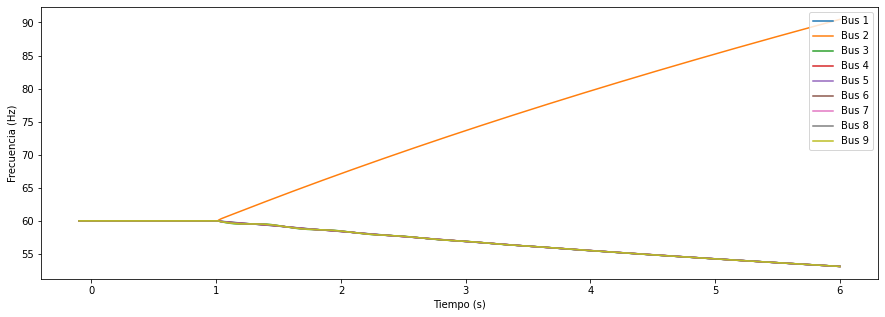

In [10]:
time = Data[Data.columns[0]][1:None].to_numpy().astype(np.float32)
fig = plt.figure(figsize=(15,5))
for bus in Data.columns:
    if 'Bus' in bus and Data[bus][0] =='m:fehz in Hz':
        # cambia de objeto a un vector numérico  => .to_numpy().astype(np.float32)
        plt.plot(time, Data[bus][1:None].to_numpy().astype(np.float32), label=bus.replace('.2','')) 
plt.legend(loc=1), plt.xlabel('Tiempo (s)'), plt.ylabel('Frecuencia (Hz)')
plt.show()

En tanto, las tensiones de barra quedan

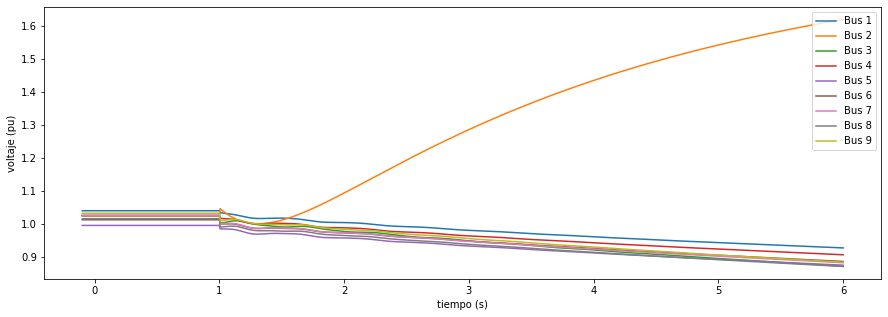

In [11]:
time = Data[Data.columns[0]][1:None].to_numpy().astype(np.float32)
fig = plt.figure(figsize=(15,5))
for bus in Data.columns:
    if 'Bus' in bus and Data[bus][0] =='m:u in p.u.':
        plt.plot(time, Data[bus][1:None].to_numpy().astype(np.float32), label=bus.replace('.2',''))
plt.legend(loc=1), plt.xlabel('tiempo (s)'), plt.ylabel('voltaje (pu)')
plt.show()

Por su parte, la potencia activa en la generación posee la siguiente dinámica

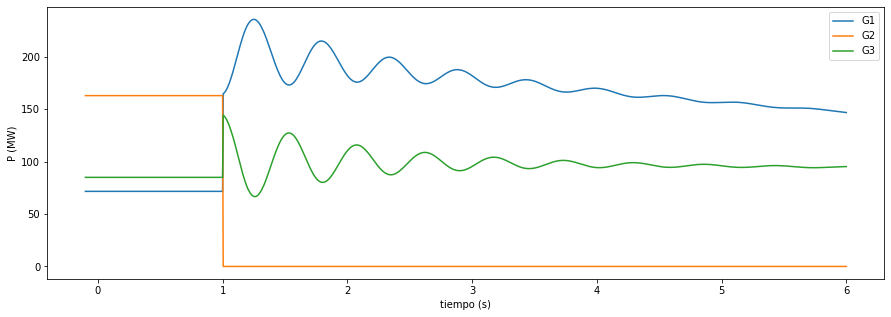

In [12]:
time = Data[Data.columns[0]][1:None].to_numpy().astype(np.float32)
fig = plt.figure(figsize=(15,5))
for sym in Data.columns:
    if 'G' in sym and Data[sym][0] =='s:P1 in MW':
        plt.plot(time, Data[sym][1:None].to_numpy().astype(np.float32), label=sym.replace('.8',''))
plt.legend(loc=1), plt.xlabel('tiempo (s)'), plt.ylabel('P (MW)') 
plt.show()

Finalmente, la velocidad del rotor queda:

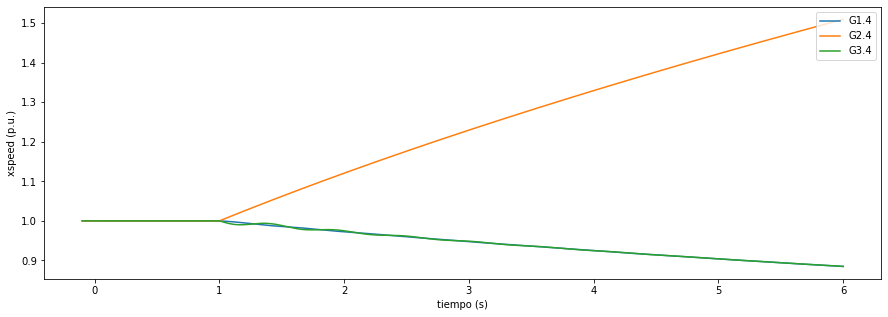

In [13]:
time = Data[Data.columns[0]][1:None].to_numpy().astype(np.float32)
fig = plt.figure(figsize=(15,5))
for sym in Data.columns:
    if 'G' in sym and Data[sym][0] =='s:xspeed in p.u.':
        plt.plot(time, Data[sym][1:None].to_numpy().astype(np.float32), label=sym.replace('.8',''))
plt.legend(loc=1), plt.xlabel('tiempo (s)'), plt.ylabel('xspeed (p.u.)') 
plt.show()